In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [2]:
mnist = torchvision.datasets.MNIST(root="datasets")

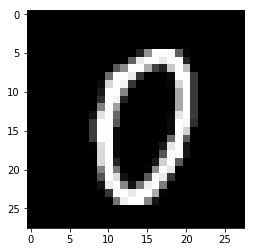

In [3]:
plt.imshow(mnist[1000][0])

In [4]:
class DigitsNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, 4)
        self.conv2 = torch.nn.Conv2d(6, 16, 4)
        
        self.maxpool = torch.nn.MaxPool2d(2)
        
        self.linear1 = torch.nn.Linear(16 * 4 * 4, 392)
        self.linear2 = torch.nn.Linear(392, 196)
        self.linear3 = torch.nn.Linear(196, 10)
        
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()
    
    def forward(self, input):
        out1 = self.conv1(input)
        out1_after_relu = self.relu(out1)
        out1_after_maxpool = self.maxpool(out1_after_relu)
        
        out2 = self.conv2(out1_after_maxpool)
        out2_after_relu = self.relu(out2)
        out2_after_maxpool = self.maxpool(out2_after_relu)
        
        flatten = out2_after_maxpool.view(out2_after_maxpool.size(0), -1)
        
        out_linear1 = self.linear1(flatten)
        out_linear1_after_relu = self.relu(out_linear1)
        
        out_linear2 = self.linear2(out_linear1_after_relu)
        out_linear2_after_relu = self.relu(out_linear2)
        
        out_linear3 = self.linear3(out_linear2_after_relu)
        return out_linear3
    
model = DigitsNet()

In [5]:
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score

def preds_to_decision(preds):
    preds = preds.data.cpu().numpy()
    shape = preds.shape
    if len(shape) == 2:
        batch_size, nb_outputs = shape
    else:
        batch_size, nb_outputs = 1, shape[0]

    if nb_outputs == 1:
        # We're in a regression setting and batch_size=1.
        preds[preds > 0] = 1
        preds[preds == 0.] = 0
        preds = preds.astype(int)
        return preds
    else:
        # Classification.
        if batch_size > 1:
            preds = np.argmax(preds, axis=1).astype(int)
            return preds
        else:
            raise NotImplementedError

class TrainingHelper(object):
    def __init__(self, nb_epochs):
        self.nb_epochs = nb_epochs - 1
        self.pbar = tqdm(total=nb_epochs)

        self.per_epoch_losses = []
        self.per_epoch_accuracy = []
        self.current_epoch_losses = None
        self.current_epoch_preds = None
        self.current_epoch_labels = None

        self.current_epoch = -1

    def add_preds(self, preds):
        preds = preds_to_decision(preds)
        self.current_epoch_preds.extend(list(preds))

    def add_labels(self, labels):
        labels = labels.data.cpu().numpy().astype(int)
        self.current_epoch_labels.extend(list(labels))

    def add_loss(self, loss):
        loss = loss.data.cpu().numpy()
        self.current_epoch_losses.extend(list(loss))

    def new_epoch(self):
        self.current_epoch += 1
        self.pbar.update(1)

        if self.current_epoch > 0:
            mean_loss = np.mean(self.current_epoch_losses)
            accuracy = accuracy_score(self.current_epoch_labels,
                                      self.current_epoch_preds)
            self.per_epoch_losses.append(mean_loss)
            self.per_epoch_accuracy.append(accuracy)

            self.pbar.set_postfix(loss=mean_loss,
                                  accuracy=accuracy)

        if self.current_epoch == self.nb_epochs:
            self.end_training()

        self.current_epoch_losses = []
        self.current_epoch_preds = []
        self.current_epoch_labels = []

    def end_training(self):

        X = range(1, self.nb_epochs+1)
        _, ax = plt.subplots(1, 1, sharex=True)
        ax.plot(X, self.per_epoch_losses, label='loss', c='#4470a9')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')

        ax2 = ax.twinx()
        ax2.plot(X, self.per_epoch_accuracy, label='accuracy', c='#49a369')
        ax2.set_ylabel('Accuracy')
        ax2.set_ylim([0.5, 1])

        ax.legend()
        ax2.legend()
        plt.show()

In [ ]:
def training(model, train_dataset, validation_dataset, epochs, lr):
    model.train()    
    loss_fn = torch.nn.CrossEntropyLoss()
    
    helper1 = TrainingHelper(epochs)
    helper2 = TrainingHelper(epochs)
    
    train_dataloader      = torch.utils.data.DataLoader(train_dataset, batch_size=64)
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=64)

    for t in range(epochs):
        helper1.new_epoch()
        for datapoint, label in train_dataloader:
            datapoint = torch.autograd.Variable(datapoint.float())
            label     = torch.autograd.Variable(label.long())

            prediction = model(datapoint)
            loss_value = loss_fn(prediction, label)

            model.zero_grad()
            loss_value.backward()

            for name, parameter in model.named_parameters():
                parameter.data = parameter.data - lr * parameter.grad.data

            helper1.add_preds(prediction.cpu())
            helper1.add_loss(loss_value.cpu())
            helper1.add_labels(label.cpu())
            
        helper2.new_epoch()
        for datapoint, label in validation_dataloader:
            datapoint = torch.autograd.Variable(datapoint.float())
            label     = torch.autograd.Variable(label.long())

            prediction = model(datapoint)

            helper2.add_preds(prediction.cpu())
            helper2.add_loss(loss_value.cpu())
            helper2.add_labels(label.cpu())

grayscale_and_tensor = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
])
            
train_dataset = torchvision.datasets.MNIST(root="datasets", transform=grayscale_and_tensor)
validation_dataset = torchvision.datasets.MNIST(root="datasets", train=False, transform=grayscale_and_tensor)

training(model, train_dataset, validation_dataset, 10, 0.01)

In [ ]:
from PIL import Image, ImageOps

def bw_image_from_array(array, threshold=128):
    bw_array = np.zeros((28, 28, 3))
    for i in range(len(array)):
        for j in range(len(array[0])):
            if array[i][j] > threshold:
                bw_array[i][j] = (0, 0, 0)
            else:
                bw_array[i][j] = (255, 255, 255)
    return bw_array

image = Image.open('test/1.png').convert('L')
bw_image = bw_image_from_array(np.array(image))
plt.imshow(bw_image)

test_input_image = Image.fromarray(np.uint8(bw_image))
test_input_image = grayscale_and_tensor(bw_image)

datapoint = test_input_image.unsqueeze(0)
datapoint = torch.autograd.Variable(torch.FloatTensor(datapoint))

probabilities = model(datapoint)
print(probabilities.data.numpy().argmax())